In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [1]:
import pandas as pd

In [2]:
train_df_path = "/Users/nijiayi/Stats_C161-261_Project/train_data_after_feature_selection.csv"
test_df_path = "/Users/nijiayi/Stats_C161-261_Project/test_data_after_feature_selection.csv"

In [3]:
from tqdm import tqdm

def load_dataset(file_path, chunk_size=1000000):
    df = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(file_path, iterator=True, chunksize=chunk_size)):
        df = pd.concat([df, chunk], ignore_index=True)
    return df

def balanced_dataset_downsampling(chunks, random_state=123):
    df = pd.DataFrame()

    if isinstance(chunks, pd.DataFrame):
        chunks = [chunks]

    for chunk in tqdm(chunks):
        chunk.reset_index(drop=True, inplace=True)

        # Separate by label
        label_1 = chunk[chunk["label"] == 1]
        label_0 = chunk[chunk["label"] == 0]

        # Downsample label 0 to match the size of label 1
        sampled_label_0 = label_0.sample(n=len(label_1), replace=False, random_state=random_state)
        sampled_chunk = pd.concat([label_1, sampled_label_0], ignore_index=True)

        df = pd.concat([df, sampled_chunk], ignore_index=True)

    return df

def separate_labels(file_path, label_column="label", chunk_size=1000000):
    df_label_0 = pd.DataFrame()
    df_label_1 = pd.DataFrame()

    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunk_size)):
        # Separate rows with label 0 and label 1
        df_label_0 = pd.concat([df_label_0, chunk[chunk[label_column] == 0]], ignore_index=True)
        df_label_1 = pd.concat([df_label_1, chunk[chunk[label_column] == 1]], ignore_index=True)


    return df_label_0, df_label_1

In [4]:
df_label_0, df_label_1 = separate_labels(file_path=train_df_path)
# Make sure that df_label_0, df_label_1 are consistent
real_data = df_label_1

4it [00:04,  1.09s/it]


In [5]:
df_label_0.shape, df_label_1.shape

((3766407, 23), (47567, 23))

In [ ]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_label_1)
for column_name, properties in metadata.columns.items():
    if properties["sdtype"] not in ["numerical", "categorical"]:
        properties["sdtype"] = "categorical"
        properties.pop("pii", None)
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "city": {
            "sdtype": "categorical"
        },
        "series_dev": {
            "sdtype": "numerical"
        },
        "emui_dev": {
            "sdtype": "numerical"
        },
        "device_name": {
            "sdtype": "numerical"
        },
        "device_size": {
            "sdtype": "numerical"
        },
        "net_type": {
            "sdtype": "categorical"
        },
        "creat_type_cd": {
            "sdtype": "categorical"
        },
        "slot_id": {
            "sdtype": "numerical"
        },
        "spread_app_id": {
            "sdtype": "numerical"
        },
        "app_second_class": {
            "sdtype": "numerical"
        },
        "u_refreshTimes": {
            "sdtype": "categorical"
        },
        "u_feedLifeCycle": {
            "sdtype": "categorical"
        },
        "user_id_count": {
            "sdtype": "numerical"
        },
        "task

In [ ]:
from sdv.single_table import CTGANSynthesizer
synthesizer = CTGANSynthesizer(metadata, verbose=True)
synthesizer.fit(df_label_1)

/opt/conda/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/conda/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.88) | Discrim. (-0.29): 100%|██████████| 300/300 [3:57:35<00:00, 47.52s/it]  


In [ ]:
synthesizer.save('ctgan_synthesizer.pkl')

In [6]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.6 MB/s eta 0:00:00


In [7]:
import joblib
synthesizer = joblib.load("/content/drive/MyDrive/ctgan_synthesizer.pkl")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
num_generated_data_needed = df_label_0.shape[0] - df_label_1.shape[0]
synthetic_data = synthesizer.sample(num_generated_data_needed)
synthetic_data.to_csv("ctgan_synthesized_data.csv")

### Evaluation

In [ ]:
synthetic_data = load_dataset(file_path="ctgan_synthesized_data.csv")

Evaluation: Fidelity

In [10]:
import joblib
synthesizer = joblib.load("/content/drive/MyDrive/ctgan_synthesizer.pkl")
synthetic_data_fidelity = synthesizer.sample(df_label_1.shape[0])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
real_data.shape, synthetic_data_fidelity.shape

((47567, 23), (47567, 23))

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

def plot_pca(real_data, synthetic_data):
    # Add source labels
    real_data["source"] = "Real"
    synthetic_data["source"] = "Synthetic"

    # Combine datasets
    combined_data = pd.concat([real_data, synthetic_data], ignore_index=True)

    numeric_data = combined_data.select_dtypes(include="number").dropna()

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(numeric_data)

    # Create DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
    pca_df["source"] = combined_data["source"]

    # Plot PCA results
    plt.figure(figsize=(10, 6))
    for source, color in zip(["Real", "Synthetic"], ["blue", "orange"]):
        subset = pca_df[pca_df["source"] == source]
        plt.scatter(subset["PCA1"], subset["PCA2"], label=source, alpha=0.5, s=10, color=color)

    plt.title("PCA of Real vs Synthetic Data")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.show()


def ks_test(real_data, synthetic_data):
    real_data_numeric = real_data.select_dtypes(include="number").dropna()
    synthetic_data_numeric = synthetic_data.select_dtypes(include="number").dropna()

    ks_results = []
    for i in range(real_data_numeric.shape[1]):
        stat, p_value = ks_2samp(real_data_numeric.iloc[:, i], synthetic_data_numeric.iloc[:, i])
        ks_results.append({"Feature": real_data_numeric.columns[i], "KS Statistic": stat, "p-value": p_value})

    ks_df = pd.DataFrame(ks_results)
    print(ks_df)
    return ks_df


def kde_plot(real_data, synthetic_data, num_features_to_plot=5):
    real_data_numeric = real_data.select_dtypes(include="number").dropna()
    synthetic_data_numeric = synthetic_data.select_dtypes(include="number").dropna()

    num_features_to_plot = min(num_features_to_plot, real_data_numeric.shape[1])

    for idx in range(num_features_to_plot):
        plt.figure(figsize=(8, 5))
        sns.kdeplot(real_data_numeric.iloc[:, idx], label="Original Minority", fill=True)
        sns.kdeplot(synthetic_data_numeric.iloc[:, idx], label="Synthetic Minority", fill=True)
        plt.title(f"Distribution of Feature {real_data_numeric.columns[idx]}")
        plt.legend()
        plt.show()

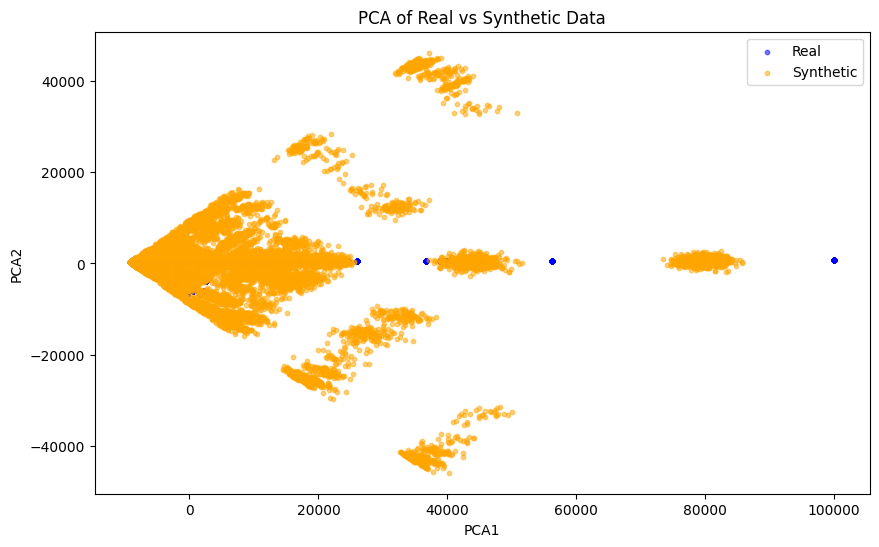

In [13]:
# PCA
plot_pca(real_data=real_data, synthetic_data=synthetic_data_fidelity)

In [14]:
# ks_test
ks_test(real_data=real_data, synthetic_data=synthetic_data_fidelity)

                          Feature  KS Statistic        p-value
0                            city      0.015998   1.019919e-05
1                      series_dev      0.124813   0.000000e+00
2                        emui_dev      0.055206   1.910336e-63
3                     device_name      0.117813  4.378388e-288
4                     device_size      0.122459  2.684844e-311
5                        net_type      0.025837   3.167868e-14
6                   creat_type_cd      0.043812   4.150803e-40
7                         slot_id      0.132529   0.000000e+00
8                   spread_app_id      0.086867  1.343992e-156
9                app_second_class      0.122101  1.765143e-309
10                 u_refreshTimes      0.057435   1.223523e-68
11                u_feedLifeCycle      0.062354   7.816343e-81
12                  user_id_count      0.031577   4.890945e-21
13                  task_id_count      0.043328   3.086329e-39
14                   adv_id_count      0.084113  7.7373

,Feature,KS Statistic,p-value
0,city,0.015998,1.019919e-05
1,series_dev,0.124813,0.000000e+00
2,emui_dev,0.055206,1.910336e-63
3,device_name,0.117813,4.378388e-288
4,device_size,0.122459,2.684844e-311
5,net_type,0.025837,3.167868e-14
6,creat_type_cd,0.043812,4.150803e-40
7,slot_id,0.132529,0.000000e+00
8,spread_app_id,0.086867,1.343992e-156
9,app_second_class,0.122101,1.765143e-309


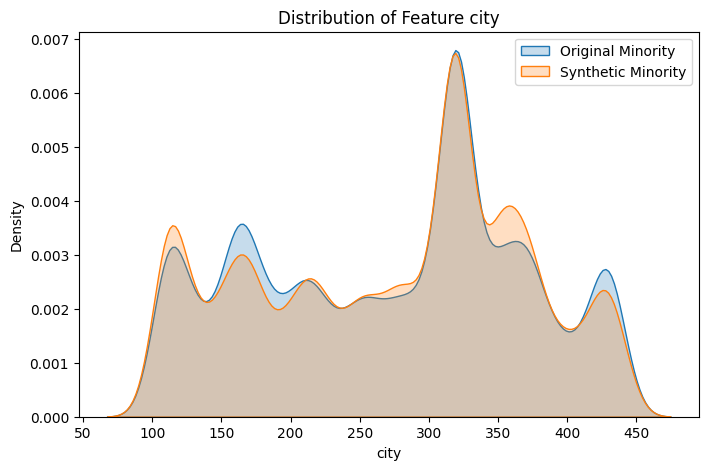

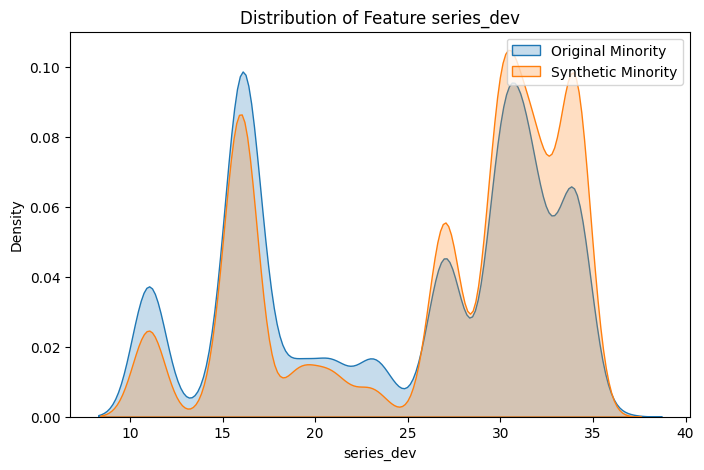

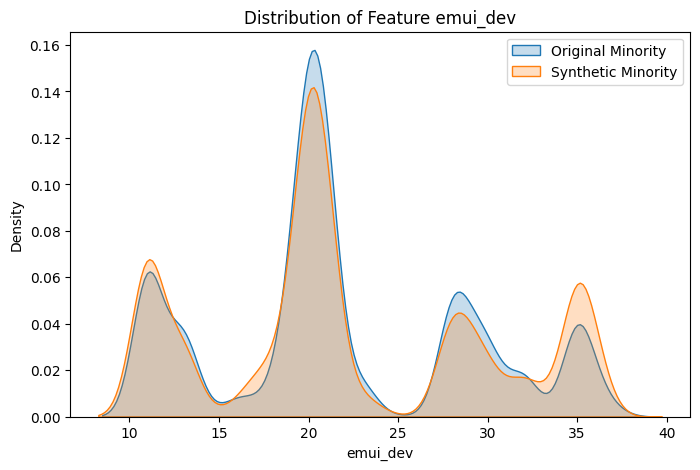

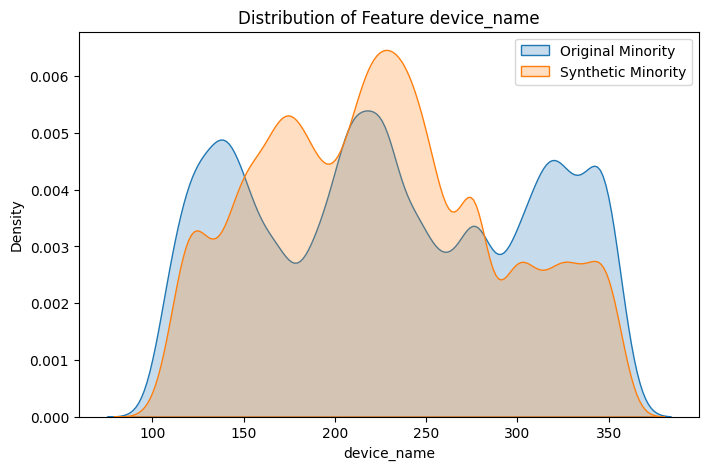

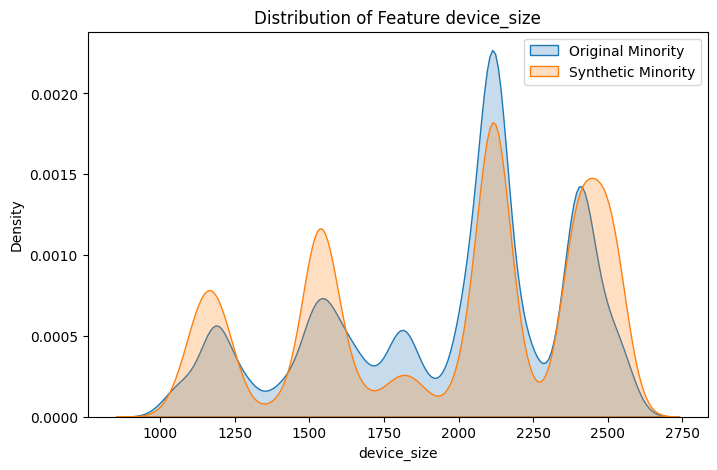

In [15]:
# KDE Plot
kde_plot(real_data=real_data, synthetic_data=synthetic_data_fidelity)

Evaluation: Utility

In [17]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.3 MB/s eta 0:00:00


In [19]:
df_label_0.shape, df_label_1.shape, synthetic_data.shape

((3766407, 23), (47567, 24), (3718840, 23))

In [20]:
df_label_0

,city,series_dev,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id,spread_app_id,app_second_class,...,task_id_count,adv_id_count,user_id_task_id_nunique,user_id_adv_prim_id_nunique,user_id_slot_id_nunique,user_id_spread_app_id_nunique,age_task_id_nunique,age_adv_id_nunique,gender_task_id_nunique,label
0,150,21,30,125,1726,7,3,17,301,14,...,139,139,30,16,7,11,7019,7834,10244,0
1,319,27,11,183,2401,7,5,35,213,23,...,1227,1227,60,32,15,20,7637,8530,8093,0
2,170,32,19,312,2117,7,8,40,168,18,...,1597,1597,115,37,14,18,8058,8936,10244,0
3,187,16,13,168,2032,7,8,12,162,14,...,492,492,24,13,9,6,8058,8936,10244,0
4,417,32,20,229,2117,4,8,20,309,13,...,8236,8236,25,20,11,8,8363,9358,10244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766402,372,21,30,338,2305,7,8,65,257,17,...,11,11,38,22,13,15,8058,8936,6898,0
3766403,352,34,28,280,2117,7,8,52,305,29,...,615,615,12,6,7,6,8058,8936,10244,0
3766404,297,19,30,228,1786,7,8,38,312,18,...,19517,19517,24,14,12,11,7019,7834,10244,0
3766405,328,20,19,190,1704,6,8,58,162,14,...,5938,892,45,20,17,4,8363,9358,10244,0


In [21]:
df_label_1

,city,series_dev,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id,spread_app_id,app_second_class,...,adv_id_count,user_id_task_id_nunique,user_id_adv_prim_id_nunique,user_id_slot_id_nunique,user_id_spread_app_id_nunique,age_task_id_nunique,age_adv_id_nunique,gender_task_id_nunique,label,source
0,411,16,35,324,2401,7,8,54,312,18,...,16232,6,6,3,6,8363,9358,10244,1,Real
1,306,30,35,278,2482,7,2,13,213,23,...,7359,54,26,10,21,5066,5546,10244,1,Real
2,106,21,12,310,2231,7,8,63,312,18,...,16330,5,4,5,3,7845,8730,10244,1,Real
3,431,32,19,312,1135,7,8,67,168,18,...,845,5,5,3,4,4321,4669,10244,1,Real
4,263,30,28,344,2032,7,5,17,213,23,...,2362,96,40,10,12,8065,9014,6898,1,Real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47562,185,16,28,164,2117,4,8,40,162,14,...,399,49,27,13,14,8065,9014,10244,1,Real
47563,162,19,30,228,1786,7,8,17,280,17,...,8950,8,7,5,6,7019,7834,10244,1,Real
47564,157,34,21,200,1631,7,10,16,181,20,...,1142,55,28,13,18,7845,8730,6898,1,Real
47565,207,21,16,349,2401,7,5,21,213,23,...,536,32,13,11,10,8065,9014,10244,1,Real


In [23]:
synthetic_data

,city,series_dev,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id,spread_app_id,app_second_class,...,task_id_count,adv_id_count,user_id_task_id_nunique,user_id_adv_prim_id_nunique,user_id_slot_id_nunique,user_id_spread_app_id_nunique,age_task_id_nunique,age_adv_id_nunique,gender_task_id_nunique,label
0,203,30,36,222,2476,6,8,12,258,29,...,10268,4295,10,3,2,5,7845,8730,10244,1
1,178,34,21,202,2179,7,8,38,117,18,...,19673,3473,3,3,14,10,8065,9014,10244,1
2,143,15,19,312,1209,7,8,64,190,13,...,2226,1313,2,3,1,5,7019,7834,10244,1
3,107,19,30,270,1527,7,8,42,306,18,...,1781,642,14,3,6,5,8058,8936,10244,1
4,263,31,20,345,2113,7,8,58,115,18,...,8061,7310,17,36,9,10,8065,9014,10244,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718835,187,16,20,240,2169,7,8,38,349,13,...,5459,5385,3,1,2,1,8058,5546,10244,1
3718836,207,16,35,184,2115,7,10,15,198,18,...,8035,8303,16,6,6,8,8058,8936,10244,1
3718837,402,17,18,298,1149,6,10,28,116,17,...,1663,1507,31,17,11,10,8363,9358,10244,1
3718838,151,30,35,223,2450,3,8,65,241,14,...,4191,4093,82,38,9,22,8363,9014,10244,1


In [25]:
import pandas as pd
from tqdm import tqdm

def load_dataset(file_path, chunk_size=1000000):
    df = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(file_path, iterator=True, chunksize=chunk_size)):
        df = pd.concat([df, chunk], ignore_index=True)
    return df

test_df = load_dataset(file_path="/content/drive/MyDrive/test_data_after_feature_selection.csv")

# Combine synthetic data and real data for the train set
combined_train_data = pd.concat([df_label_0, df_label_1, synthetic_data], ignore_index=True)
X_train = combined_train_data.drop(columns=["label", "source"])
y_train = combined_train_data["label"]
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

1it [00:00, 32.09it/s]


In [26]:
combined_train_data

,city,series_dev,emui_dev,device_name,device_size,net_type,creat_type_cd,slot_id,spread_app_id,app_second_class,...,adv_id_count,user_id_task_id_nunique,user_id_adv_prim_id_nunique,user_id_slot_id_nunique,user_id_spread_app_id_nunique,age_task_id_nunique,age_adv_id_nunique,gender_task_id_nunique,label,source
0,150,21,30,125,1726,7,3,17,301,14,...,139,30,16,7,11,7019,7834,10244,0,NaN
1,319,27,11,183,2401,7,5,35,213,23,...,1227,60,32,15,20,7637,8530,8093,0,NaN
2,170,32,19,312,2117,7,8,40,168,18,...,1597,115,37,14,18,8058,8936,10244,0,NaN
3,187,16,13,168,2032,7,8,12,162,14,...,492,24,13,9,6,8058,8936,10244,0,NaN
4,417,32,20,229,2117,4,8,20,309,13,...,8236,25,20,11,8,8363,9358,10244,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532809,187,16,20,240,2169,7,8,38,349,13,...,5385,3,1,2,1,8058,5546,10244,1,NaN
7532810,207,16,35,184,2115,7,10,15,198,18,...,8303,16,6,6,8,8058,8936,10244,1,NaN
7532811,402,17,18,298,1149,6,10,28,116,17,...,1507,31,17,11,10,8363,9358,10244,1,NaN
7532812,151,30,35,223,2450,3,8,65,241,14,...,4093,82,38,9,22,8363,9014,10244,1,NaN


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler

def evaluate(method, X_train, y_train, X_test, y_test, random_state=123):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if method == "logistic_regression":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
    elif method == "random_forest":
        model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    elif method == "catboost":
        model = CatBoostClassifier(verbose=0, random_state=random_state)
    else:
        raise ValueError("Unsupported method. Choose from: 'logistic_regression', 'random_forest', 'catboost'.")

    model.fit(X_train_scaled, y_train)

    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)

    metrics = {
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }

    print(f"Evaluation metrics for {method}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.5f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color="b", label=f"{method} ROC Curve (AUC = {metrics['ROC-AUC']:.2f})")
    plt.plot([0, 1], [0, 1], color="r", linestyle="--", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{method} ROC Curve")
    plt.legend()
    plt.show()

    return metrics

Evaluation metrics for logistic_regression:
ROC-AUC: 0.73180
Accuracy: 0.66961
Recall: 0.60335
F1-Score: 0.64616


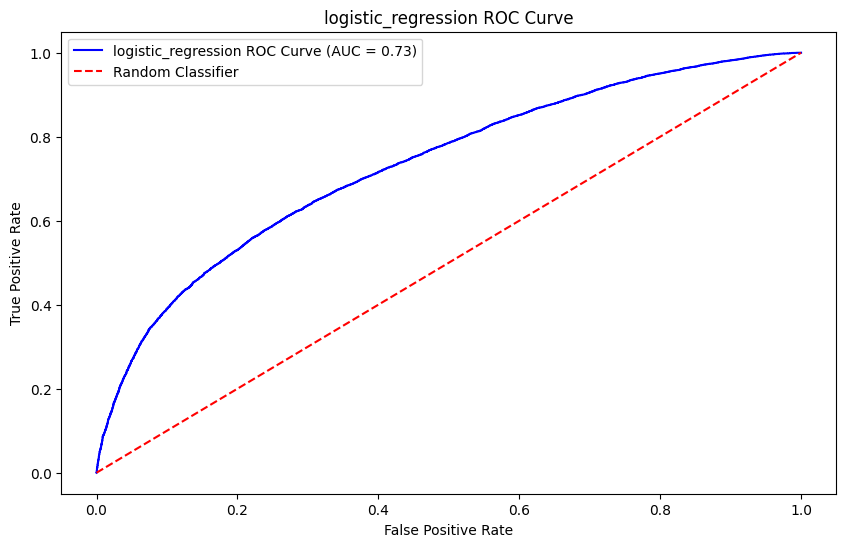

{'ROC-AUC': 0.731802873608864,
 'Accuracy': 0.6696098217288934,
 'Recall': 0.603346787756475,
 'F1-Score': 0.6461635446685879}

In [28]:
# Logistic Regression
evaluate(method="logistic_regression", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Evaluation metrics for random_forest:
ROC-AUC: 0.76745
Accuracy: 0.58565
Recall: 0.17693
F1-Score: 0.29922


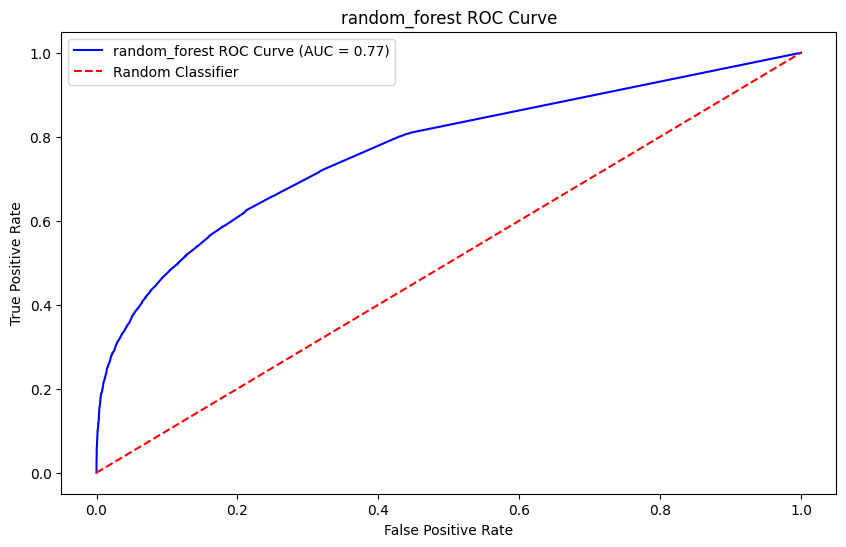

{'ROC-AUC': 0.7674486307646722,
 'Accuracy': 0.5856458123107972,
 'Recall': 0.17692566431214263,
 'F1-Score': 0.2992249164474152}

In [29]:
# Random Forest
evaluate(method="random_forest", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Evaluation metrics for catboost:
ROC-AUC: 0.78439
Accuracy: 0.51665
Recall: 0.03389
F1-Score: 0.06552


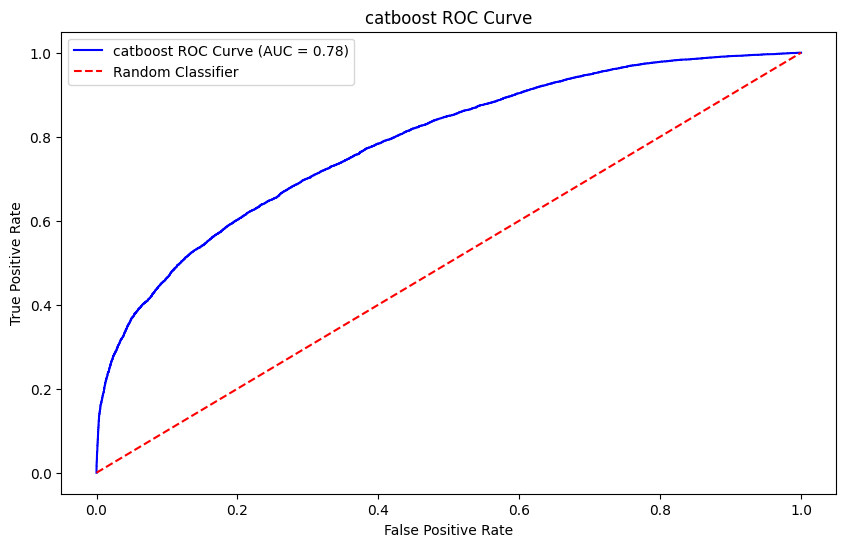

{'ROC-AUC': 0.7843944672361829,
 'Accuracy': 0.5166498486377397,
 'Recall': 0.03388832828792466,
 'F1-Score': 0.06551780198341733}

In [30]:
# Catboost
evaluate(method="catboost", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)